# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

# INTRODUCCION


La empresa de telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.Se realizara un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Se tienen los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. 



# OBJETIVO

Como analista de datos para el operador de telecomunicaciones Megaline tu objetivo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.


## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import ttest_ind
import calendar

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

calls=pd.read_csv('megaline_calls.csv')
internet=pd.read_csv('megaline_internet.csv')
messages=pd.read_csv('megaline_messages (1).csv')
plans=pd.read_csv('megaline_plans (1).csv')
users=pd.read_csv('megaline_users.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

En este dataframe contienen información sobre cada uno de los planes, el plan Surf cuenta con 500 minutos al mes, 50 SMS y 15GB de datos por un costo mensual de 20 dólares, si se exceden los límites del paquete se cobrará un extra de 3 centavos por minuto, 3 centavos el mensaje y 10 dólares por GB. Por otro lado para el plan Ultimate ofrece 3000 minutos al mes, 1000 SMS y 30GB por un costo mensual total de 70 dólares, al exceder estos límites se cobrará un extra de 1 centavo por minutos, 1 centavo por mensaje y 7 dólares por GB.

La única corrección necesaria será transformar los megabytes de los planes a gigabytes para luego realizar las correctas comparaciones.

## Corregir datos

In [5]:

plans['gb_per_month_included']=np.ceil(plans['mb_per_month_included']/1024)


## Enriquecer los datos

In [6]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
users.sample(6)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
125,1125,Assunta,Carver,39,"North Port-Sarasota-Bradenton, FL MSA",2018-08-16,surf,NaN
382,1382,Luci,Kidd,49,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-06-22,ultimate,NaN
310,1310,Vincent,Fry,73,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-11-29,surf,NaN
180,1180,Wonda,Hays,24,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-01,surf,2018-12-22
487,1487,Elton,Simpson,18,"Cape Coral-Fort Myers, FL MSA",2018-08-16,ultimate,NaN
383,1383,Margarito,Mccoy,52,"Tampa-St. Petersburg-Clearwater, FL MSA",2018-10-10,ultimate,NaN


In [9]:
users[~users['churn_date'].isna()].head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07


In [10]:
#usarios que se han dado de bajo de su plan mensual
print(users[~users['churn_date'].isna()].count())

user_id       34
first_name    34
last_name     34
age           34
city          34
reg_date      34
plan          34
churn_date    34
dtype: int64


El dataframe Users tiene la inforamcion de los usuarios las columnas  reg_date y churn_date son de tipo objeto, así que será necesario transformar estos valores a tipo datetime,  observamos que  la columna churn_date tiene valores ausentes.

Los valores ausentes en la columna churn_date se generan debido a que estos usarios son los que han continuado en usando su plan telefonico por lo cual no tienen una fecha de abandono , generando asi los valores nulos, checamos y obtenemos que solo 34 usarios son los que han abandonado su plan y tienen una fecha. 

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

In [11]:
# Convertimos estas columnas a formato 
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date']=pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
print('Duplicados',users.duplicated().sum())

users=users.drop_duplicates()

Duplicados 0


In [12]:
users.info()
print()
users.sample(6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 35.2+ KB



,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
348,1348,Carl,Rutledge,60,"Detroit-Warren-Dearborn, MI MSA",2018-10-05,surf,NaT
312,1312,Kory,Emerson,42,"Fresno, CA MSA",2018-01-26,surf,NaT
317,1317,Ruthanne,Heath,70,"Phoenix-Mesa-Chandler, AZ MSA",2018-11-11,ultimate,NaT
194,1194,Robert,Mclean,40,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-05-31,surf,NaT
411,1411,Man,Fleming,64,"Rochester, NY MSA",2018-08-10,surf,NaT
479,1479,Keesha,Burnett,44,"Riverside-San Bernardino-Ontario, CA MSA",2018-11-12,surf,NaT


### Enriquecer los datos

In [13]:
# Creo una nueva columna llamada plan que luego nos servira para unir las tarifas con los usuarios
users['plan_name']=users['plan']

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   plan_name   500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 39.1+ KB


In [15]:
users.sample(6)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,plan_name
185,1185,Loria,Freeman,47,"Louisville/Jefferson County, KY-IN MSA",2018-01-14,ultimate,NaT,ultimate
363,1363,Sandee,Lott,33,"Seattle-Tacoma-Bellevue, WA MSA",2018-01-05,ultimate,2018-08-16,ultimate
393,1393,Wilfredo,Rosa,44,"Knoxville, TN MSA",2018-10-29,surf,NaT,surf
37,1037,Reena,Velazquez,20,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-11,ultimate,NaT,ultimate
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30,surf
126,1126,Jermaine,Mcguire,68,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-02,ultimate,NaT,ultimate


## Llamadas

In [16]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()
print()
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB



,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [17]:
# Imprime una muestra de datos para las llamadas
calls.sample(6)

,id,user_id,call_date,duration
1346,1007_367,1007,2018-11-19,1.79
19531,1073_406,1073,2018-04-14,10.09
57638,1208_20,1208,2018-12-30,4.02
92864,1334_232,1334,2018-09-02,9.54
20401,1077_368,1077,2018-04-17,2.41
60007,1215_392,1215,2018-12-08,9.27


In [18]:
print(f'Llamadas con duracion de 0:',calls[calls['duration']==0]['id'].count())

Llamadas con duracion de 0: 26834


In [19]:
lost_calls=calls[calls['duration']==0]

In [20]:
print(f'Llamadas con duracion diferente de 0:',calls[calls['duration']!=0]['id'].count())

Llamadas con duracion diferente de 0: 110901


In [21]:
len(lost_calls)/len(calls)*100

19.482339274694162

In [22]:
calls=calls[calls['duration']!=0]

In [23]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         110901 non-null  object 
 1   user_id    110901 non-null  int64  
 2   call_date  110901 non-null  object 
 3   duration   110901 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


En este dataframe cada fila corresponde a una llamada realizada por uno de los 500 clientes  y cada llamada tiene registrada su duración y fecha. Al analizar los resultados de info podemos observar que la fecha de cada llamada es de tipo objeto, será necesario realizar la correcta transformación a tipo datetime y tambien será necesario redondear los valores de la columna duration.

Sobre los valores cero al parecer estas llamadas atípicamente cortas están relacionadas con llamadas perdidas, creamos la columna llamadas perdidas  para ver el  porcentaje que representan ,hay un total de 26834 llamadas con duración de 0 minutos, que representan un 19.48% del dataset , si bien el porcentaje es alto, hay que tomar en consideración que estos valores corresponden a llamadas perdidas, ya que estamos buscando los ingresos mensuales generados y una llamada de este tipo no genera ninguna ganancia a la empresa y  su eliminación no afectará los cálculos posteriores ya que los valores cero no cambian los resultados de minutos utilizados al mes, pero si alterará el número real de llamadas realizadas por el usuario, haciéndonos creer que se realizaron más llamadas por mes ,filtramo nuestro dataset solo con  aquellas llamadas que no sean igual a cero.

### Corregir los datos

In [73]:
#Convertir a tipo de dato de fecha
calls['call_date']=pd.to_datetime(calls['call_date'])
print()
#Redonde duration
calls['duration']=np.ceil(calls['duration']).astype(int)
print()
#Eliminamos datos duplicados
print('Duplicados',users.duplicated().sum())

calls.drop_duplicates(inplace=True)



Duplicados 0


In [25]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         110901 non-null  object        
 1   user_id    110901 non-null  int64         
 2   call_date  110901 non-null  datetime64[ns]
 3   duration   110901 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 3.8+ MB


### Enriquecer los datos

In [26]:
# Creamos la columnas dia de la semana y meses para un mejor manejo de datos en su analisis
calls['day_of_week'] = calls['call_date'].dt.day_name()
calls['month'] = calls['call_date'].dt.month

# Imprimir información actualizada
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           110901 non-null  object        
 1   user_id      110901 non-null  int64         
 2   call_date    110901 non-null  datetime64[ns]
 3   duration     110901 non-null  int32         
 4   day_of_week  110901 non-null  object        
 5   month        110901 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(2)
memory usage: 5.5+ MB


In [27]:
calls.sample(6)

,id,user_id,call_date,duration,day_of_week,month
110973,1390_422,1390,2018-12-15,1,Saturday,12
78495,1281_54,1281,2018-08-01,2,Wednesday,8
48352,1174_329,1174,2018-06-24,8,Sunday,6
101774,1362_532,1362,2018-06-09,5,Saturday,6
65139,1236_429,1236,2018-10-12,6,Friday,10
111495,1391_373,1391,2018-09-17,4,Monday,9


In [28]:
duration_by_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc= ['sum', 'count']).reset_index()
duration_by_month.columns = ['user_id', 'month', 'min_per_month', 'calls_per_month']

duration_by_month

,user_id,month,min_per_month,calls_per_month
0,1000,12,124,16
1,1001,8,182,22
2,1001,9,315,38
3,1001,10,393,47
4,1001,11,426,49
...,...,...,...,...
2251,1498,12,339,32
2252,1499,9,346,35
2253,1499,10,385,41
2254,1499,11,308,39


## Mensajes

In [29]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()
print()
messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB



,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


In [30]:
# Imprime una muestra de datos para los mensajes
messages.sample(6)


,id,user_id,message_date
52140,1336_82,1336,2018-07-18
66029,1431_68,1431,2018-11-14
44609,1298_65,1298,2018-12-30
29391,1181_35,1181,2018-09-12
57657,1363_49,1363,2018-12-05
30373,1191_78,1191,2018-10-09


En este dataframe cada fila corresponde a un mensaje enviado por uno de nuestros 500 usuarios, y cada mensaje tiene registrada la fecha cuando se envió , no tiene valores ausentes , tenemos que la columna message_date es de tipo objeto, por lo que será necesario convertir a tipo datetime. 

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [31]:
#Convertir a tipo de dato de fecha
messages['message_date']=pd.to_datetime(messages['message_date'])



### Enriquecer los datos

In [32]:
# Creamos la columnas dia de la semana y meses para un mejor manejo de datos en su analisis
messages['month'] = messages['message_date'].dt.month
messages['day_of_week'] = messages['message_date'].dt.day_name()
# Verificar los cambios
messages.sample(6)


,id,user_id,message_date,month,day_of_week
33957,1214_51,1214,2018-03-20,3,Tuesday
67622,1439_16,1439,2018-08-22,8,Wednesday
31812,1196_298,1196,2018-12-23,12,Sunday
5089,1046_151,1046,2018-09-19,9,Wednesday
34396,1215_310,1215,2018-12-11,12,Tuesday
670,1006_660,1006,2018-12-14,12,Friday


## Internet

In [33]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()
print()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB



,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [34]:
# Imprime una muestra de datos para el tráfico de internet
internet.sample(6)

,id,user_id,session_date,mb_used
80246,1374_322,1374,2018-07-31,1361.42
98468,1465_414,1465,2018-07-28,0.00
90294,1416_24,1416,2018-10-11,78.40
95834,1447_24,1447,2018-11-14,392.75
69613,1325_15,1325,2018-12-15,391.60
43434,1193_300,1193,2018-07-30,470.44


Al igual que los otros dataframes cada fila  corresponde a los megabytes  diarios utilizados por cada uno de nuestros 500 clientes, con su correspondiente id de sesión y fecha en la que se gastaron los datos,observamos que  sessión_date se encuentra como tipo objeto, se convertirar en un  tipo datetime.

En la columna mb_used los valores deben convertise de megabytes a gigabytes, ya que la empresa Megaline redondea los gastos mensuales de datos hacia arriba.


### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [35]:
#Se convierte la columna a tipo datatime
internet['session_date']=pd.to_datetime(internet['session_date'])

#Convertir de MB a GB
internet['gb_used'] =internet['mb_used'] / 1024
# internet['gb_used'] = np.ceil(internet['mb_used'] / 1024)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.0+ MB


In [36]:
internet.head()

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590


### Enriquecer los datos

In [75]:
# Creamos la columnas dia de la semana y meses para un mejor manejo de datos en su analisis
internet['month'] = internet['session_date'].dt.month
internet['day_of_week'] = internet['session_date'].dt.day_name()

internet.info()
print()
print('Duplicados',internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
 5   month         104825 non-null  int64         
 6   day_of_week   104825 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 5.6+ MB

Duplicados 0


In [38]:
internet.sample(6)

,id,user_id,session_date,mb_used,gb_used,month,day_of_week
78884,1368_46,1368,2018-10-29,183.46,0.179160,10,Monday
37877,1171_248,1171,2018-10-31,265.23,0.259014,10,Wednesday
80518,1376_71,1376,2018-12-26,0.00,0.000000,12,Wednesday
21768,1099_523,1099,2018-07-21,25.97,0.025361,7,Saturday
43606,1194_24,1194,2018-10-21,259.58,0.253496,10,Sunday
4230,1027_58,1027,2018-12-14,0.00,0.000000,12,Friday


## Estudiar las condiciones de las tarifas

In [39]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


In [40]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
call_user_month=calls.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id': 'calls_per_month'})
call_user_month.head()

,user_id,month,calls_per_month
0,1000,12,16
1,1001,8,22
2,1001,9,38
3,1001,10,47
4,1001,11,49


In [41]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_user_month=calls.groupby(['user_id', 'month'])['duration'].sum().reset_index().rename(columns={'duration': 'minutes_per_month'})
minutes_user_month.head()

,user_id,month,minutes_per_month
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [42]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_user_month=messages.groupby(['user_id', 'month'])['id'].count().reset_index().rename(columns={'id': 'messages_per_month'})
messages_user_month.head()

,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [43]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
traffic_user_month = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index().rename(columns={'gb_used': 'traffic_per_month'})
traffic_user_month['traffic_per_month'] = np.ceil(traffic_user_month['traffic_per_month']).astype(int)
traffic_user_month.head()

,user_id,month,traffic_per_month
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


In [45]:
traffic_user_month[traffic_user_month['user_id']==1001]

,user_id,month,traffic_per_month
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19
5,1001,12,19


In [46]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
monthly_data = call_user_month.merge(
    minutes_user_month, how='outer', on=['user_id', 'month']
).merge(
    messages_user_month, how='outer', on=['user_id', 'month']
).merge(
    traffic_user_month, how='outer', on=['user_id', 'month']
).reset_index()


In [47]:
monthly_data

,index,user_id,month,calls_per_month,minutes_per_month,messages_per_month,traffic_per_month
0,0,1000,12,16.0,124.0,11.0,2.0
1,1,1001,8,22.0,182.0,30.0,7.0
2,2,1001,9,38.0,315.0,44.0,14.0
3,3,1001,10,47.0,393.0,53.0,22.0
4,4,1001,11,49.0,426.0,36.0,19.0
...,...,...,...,...,...,...,...
2288,2288,1407,11,NaN,NaN,1.0,1.0
2289,2289,1482,10,NaN,NaN,2.0,NaN
2290,2290,1094,10,NaN,NaN,NaN,2.0
2291,2291,1108,12,NaN,NaN,NaN,1.0


In [48]:
# Añade la información de la tarifa
# Para esto usamosla tabla de users obtenemos el plan que tiene cada usuario y los unimos con la columna user_id
user_monthly_data = pd.merge(monthly_data, users, on='user_id', how='outer').reset_index()


In [49]:
user_monthly_data.head()

,level_0,index,user_id,month,calls_per_month,minutes_per_month,messages_per_month,traffic_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,plan_name
0,0,0.0,1000,12.0,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,ultimate
1,1,1.0,1001,8.0,22.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf
2,2,2.0,1001,9.0,38.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf
3,3,3.0,1001,10.0,47.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf
4,4,4.0,1001,11.0,49.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf


In [50]:
# Hacemos el calculo de ingresos mensuales por usuario:
def calculate_monthly_income(row):
    min_total = 0
    mess_total = 0
    gb_total = 0
    
    plan = row['plan']
    min_per_month = row['minutes_per_month']
    messages_per_month = row['messages_per_month']
    gb_per_month = row['traffic_per_month']
    
    if plan == 'surf':
        min_total += max(0, min_per_month - 500) * 0.03
        mess_total += max(0, messages_per_month - 50) * 0.03
        gb_total += max(0, gb_per_month - 15) * 10
        income = 20 + min_total + mess_total + gb_total
    
    elif plan == 'ultimate':
        min_total += max(0, min_per_month - 3000) * 0.01
        mess_total += max(0, messages_per_month - 1000) * 0.01
        gb_total += max(0, gb_per_month - 30) * 7
        income = 70 + min_total + mess_total + gb_total
    
    else:
        income = 0  # Plan desconocido
    
    return income


In [51]:
user_monthly_data['monthly_income'] = user_monthly_data.apply(calculate_monthly_income, axis=1)

In [52]:
user_monthly_data.sample(10)

,level_0,index,user_id,month,calls_per_month,minutes_per_month,messages_per_month,traffic_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,plan_name,monthly_income
1652,1652,1647.0,1362,7.0,103.0,955.0,55.0,15.0,Kenyetta,Mcknight,65,"Denver-Aurora-Lakewood, CO MSA",2018-01-18,surf,NaT,surf,33.80
1654,1654,1649.0,1362,9.0,70.0,620.0,53.0,13.0,Kenyetta,Mcknight,65,"Denver-Aurora-Lakewood, CO MSA",2018-01-18,surf,NaT,surf,23.69
1709,1709,1704.0,1374,6.0,53.0,414.0,66.0,35.0,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaT,surf,220.48
1749,1749,1744.0,1384,10.0,37.0,369.0,83.0,25.0,Dominique,Good,36,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-06-09,ultimate,NaT,ultimate,70.00
2154,2154,2148.0,1474,12.0,35.0,285.0,40.0,18.0,Randee,Carpenter,26,"Bakersfield, CA MSA",2018-08-26,surf,NaT,surf,50.00
1523,1523,1519.0,1336,5.0,73.0,587.0,88.0,17.0,Vance,Bradshaw,34,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-04-04,surf,NaT,surf,43.75
1376,1376,1373.0,1304,12.0,50.0,533.0,59.0,23.0,Dominque,Cole,69,"Birmingham-Hoover, AL MSA",2018-10-28,ultimate,NaT,ultimate,70.00
998,998,996.0,1214,7.0,48.0,467.0,24.0,17.0,Emil,Robles,34,"San Francisco-Oakland-Berkeley, CA MSA",2018-01-01,ultimate,NaT,ultimate,70.00
302,302,301.0,1066,6.0,60.0,457.0,34.0,17.0,Ariel,Woods,61,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-08,surf,NaT,surf,40.00
2026,2026,2020.0,1443,11.0,21.0,187.0,5.0,13.0,Genaro,Quinn,58,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-11,surf,NaT,surf,20.00


In [53]:
# Comprobamos que nuestro codigo funcione escogiendo un usario aleatorio
user_monthly_data[user_monthly_data['user_id']==1001]

,level_0,index,user_id,month,calls_per_month,minutes_per_month,messages_per_month,traffic_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,plan_name,monthly_income
1,1,1.0,1001,8.0,22.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,20.00
2,2,2.0,1001,9.0,38.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,20.00
3,3,3.0,1001,10.0,47.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,90.09
4,4,4.0,1001,11.0,49.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,60.00
5,5,5.0,1001,12.0,46.0,412.0,44.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,60.00


In [54]:
user_monthly_data[user_monthly_data['user_id']==1001]

,level_0,index,user_id,month,calls_per_month,minutes_per_month,messages_per_month,traffic_per_month,first_name,last_name,age,city,reg_date,plan,churn_date,plan_name,monthly_income
1,1,1.0,1001,8.0,22.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,20.00
2,2,2.0,1001,9.0,38.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,20.00
3,3,3.0,1001,10.0,47.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,90.09
4,4,4.0,1001,11.0,49.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,60.00
5,5,5.0,1001,12.0,46.0,412.0,44.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,surf,60.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

In [55]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
average_call_duration = user_monthly_data.groupby(['plan_name', 'month'])['calls_per_month'].mean().unstack()
average_call_duration

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
plan_name,,,,,,,,,,,,
surf,24.00,33.111111,37.869565,39.700000,45.920000,48.697917,51.458333,47.044025,47.486911,49.839827,48.826715,53.996785
ultimate,21.25,55.166667,36.583333,39.047619,45.965517,44.022222,47.355932,48.000000,48.930233,51.504762,50.752000,52.838926


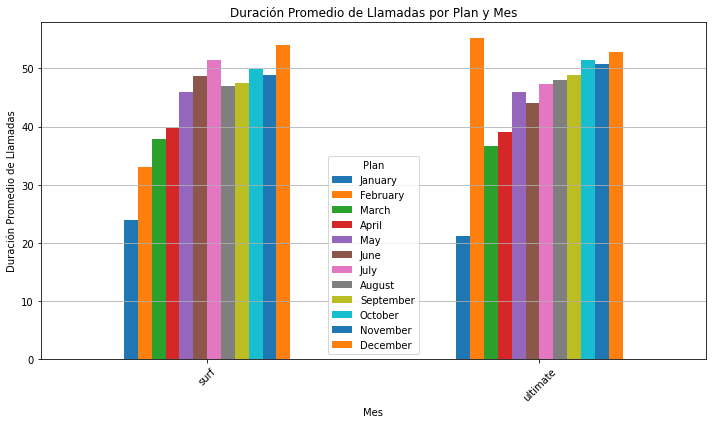

In [56]:
# Obtén los nombres de los meses en lugar de números
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Traza un gráfico de barras
average_call_duration.columns = month_names  
average_call_duration.plot(kind='bar', figsize=(10, 6))
plt.title('Duración Promedio de Llamadas por Plan y Mes')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas')
plt.legend(title='Plan')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

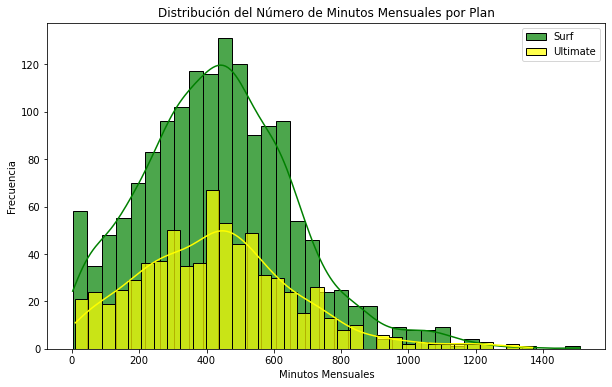

In [57]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

surf_data = user_monthly_data[user_monthly_data['plan_name'] == 'surf']['minutes_per_month']
ultimate_data = user_monthly_data[user_monthly_data['plan_name'] == 'ultimate']['minutes_per_month']

plt.figure(figsize=(10, 6))
sns.histplot(surf_data, bins=35, kde=True, color='green', label='Surf', alpha=0.7)
sns.histplot(ultimate_data, bins=35, kde=True, color='yellow', label='Ultimate', alpha=0.7)
plt.title('Distribución del Número de Minutos Mensuales por Plan')
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [58]:
# Calcula la media y la varianza de la duración mensual de llamadas.
call_duration_stats = user_monthly_data.groupby(['plan_name', 'month'])['minutes_per_month'].agg(['mean', 'var']).reset_index()
call_duration_stats

,plan_name,month,mean,var
0,surf,1.0,203.000000,15842.000000
1,surf,2.0,297.000000,52226.500000
2,surf,3.0,330.000000,35809.363636
3,surf,4.0,351.540000,50866.743265
4,surf,5.0,410.240000,56938.779459
5,surf,6.0,435.791667,44094.061404
6,surf,7.0,453.733333,59802.012325
7,surf,8.0,417.849057,52122.749224
8,surf,9.0,420.732984,44579.912538
9,surf,10.0,440.891775,48699.905628


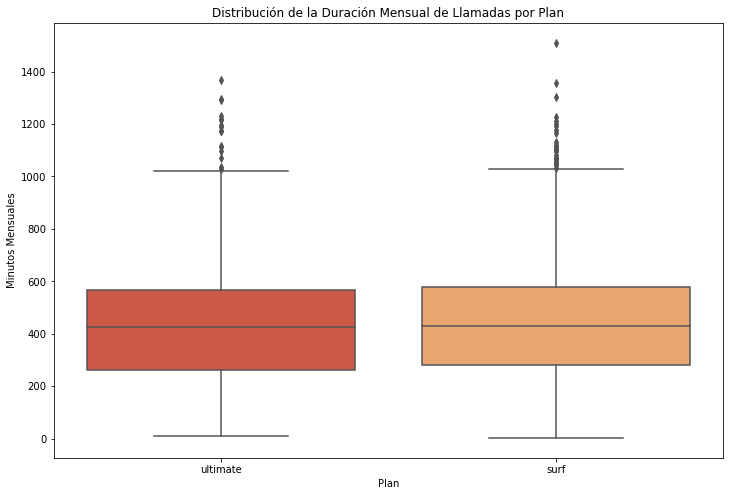

In [59]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
custom_palette = sns.color_palette("RdYlBu")
plt.figure(figsize=(12, 8))
sns.boxplot(x='plan_name', y='minutes_per_month', data=user_monthly_data,palette=custom_palette)
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Minutos Mensuales')
plt.show()

Ambos planes, "surf" y "ultimate", muestran un aumento general en la cantidad media  a lo largo del año. Este aumento podría deberse a factores estacionales o a una mayor adopción de servicios a lo largo del tiempo.Parece que el plan "surf" tiene una media y varianza más baja en comparación con el plan "ultimate". Esto sugiere que los usuarios de "ultimate" tienden a utilizar más los servicios ofrecidos y que hay una mayor variabilidad en su comportamiento.Los usuarios de ambos planes podrían estar aumentando gradualmente su uso de servicios a lo largo del año, lo que podría indicar una mayor dependencia de los servicios ofrecidos o una mayor familiaridad con ellos.



### Mensajes

In [60]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

message_stats = user_monthly_data.groupby(['plan_name', 'month'])['messages_per_month'].agg(['mean', 'var']).reset_index()
message_stats



,plan_name,month,mean,var
0,surf,1.0,21.000000,NaN
1,surf,2.0,21.600000,512.800000
2,surf,3.0,21.937500,352.062500
3,surf,4.0,24.166667,534.028571
4,surf,5.0,33.017857,867.945130
5,surf,6.0,33.616438,936.406393
6,surf,7.0,35.945055,907.985836
7,surf,8.0,37.596774,1013.315762
8,surf,9.0,39.523179,943.051126
9,surf,10.0,42.433862,1234.491613


In [61]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
traffic_stats = user_monthly_data.groupby(['plan_name', 'month'])['traffic_per_month'].agg(['mean', 'var']).reset_index()
traffic_stats

,plan_name,month,mean,var
0,surf,1.0,5.000000,18.000000
1,surf,2.0,12.222222,41.444444
2,surf,3.0,13.565217,63.984190
3,surf,4.0,12.469388,54.212585
4,surf,5.0,14.302632,56.267193
5,surf,6.0,15.810526,43.559462
6,surf,7.0,17.016667,59.579552
7,surf,8.0,17.201258,67.263036
8,surf,9.0,16.777202,48.038644
9,surf,10.0,17.632479,57.555335


In [76]:
user_monthly_data.columns

Index(['level_0', 'index', 'user_id', 'month', 'calls_per_month',
       'minutes_per_month', 'messages_per_month', 'traffic_per_month',
       'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date', 'plan_name', 'monthly_income', 'region'],
      dtype='object')

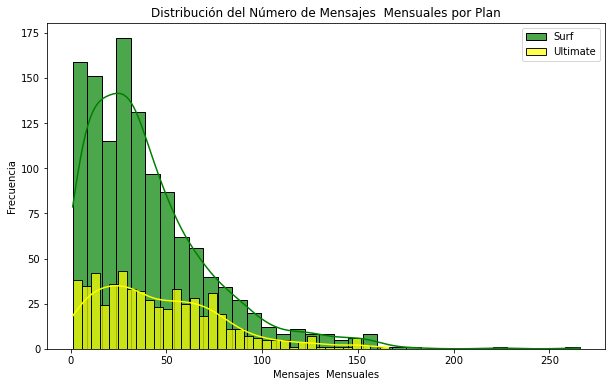

In [80]:
surf_data = user_monthly_data[user_monthly_data['plan_name'] == 'surf']['messages_per_month']
ultimate_data = user_monthly_data[user_monthly_data['plan_name'] == 'ultimate']['messages_per_month']

plt.figure(figsize=(10, 6))
sns.histplot(surf_data, bins=35, kde=True, color='green', label='Surf', alpha=0.7)
sns.histplot(ultimate_data, bins=35, kde=True, color='yellow', label='Ultimate', alpha=0.7)
plt.title('Distribución del Número de Mensajes  Mensuales por Plan')
plt.xlabel('Mensajes  Mensuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Para ambos planes ("surf" y "ultimate"), parece haber una tendencia de crecimiento en el número medio de mensajes enviados por mes a lo largo del año. Esto puede indicar un aumento en la actividad de mensajería de los usuarios con el tiempo.

La varianza en el número de mensajes enviados por mes también varía entre los meses. Por ejemplo, en el plan "surf", la varianza parece aumentar en los meses de verano (de mayo a agosto), lo que podría indicar una mayor variabilidad en el comportamiento de mensajería durante esos meses.parece que los usuarios del plan "ultimate" tienden a enviar más mensajes en promedio que los usuarios del plan "surf" en la mayoría de los meses. Sin embargo, la varianza en el número de mensajes también es más alta en el plan "ultimate" en comparación con el plan "surf".

### Internet

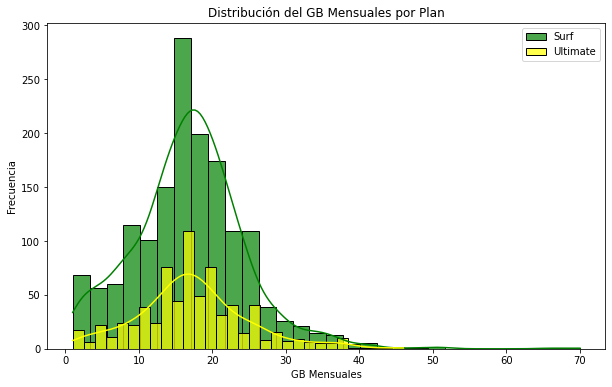

In [62]:
surf_data = user_monthly_data[user_monthly_data['plan_name'] == 'surf']['traffic_per_month']
ultimate_data = user_monthly_data[user_monthly_data['plan_name'] == 'ultimate']['traffic_per_month']

plt.figure(figsize=(10, 6))
sns.histplot(surf_data, bins=30, kde=True, color='green', label='Surf', alpha=0.7)
sns.histplot(ultimate_data, bins=30, kde=True, color='yellow', label='Ultimate', alpha=0.7)
plt.title('Distribución del GB Mensuales por Plan')
plt.xlabel('GB Mensuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Los usuarios del plan "ultimate" tienden a consumir más tráfico de Internet en promedio en comparación con los usuarios del plan "surf". Esto es evidente en la mayoría de los meses del año.
Varianza en el tráfico mensual: La varianza en el tráfico de Internet consumido por mes varía entre los meses y entre los dos planes. Por ejemplo, algunos meses muestran una varianza más alta que otros, lo que podría indicar una mayor variabilidad en el comportamiento de consumo de datos de los usuarios durante esos meses específicos.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [63]:
user_monthly_data.columns

Index(['level_0', 'index', 'user_id', 'month', 'calls_per_month',
       'minutes_per_month', 'messages_per_month', 'traffic_per_month',
       'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date', 'plan_name', 'monthly_income'],
      dtype='object')

In [64]:
general_users = user_monthly_data[['user_id','minutes_per_month', 'traffic_per_month', 'messages_per_month','plan','monthly_income']]
# filtramos los datos eliminando datos atipicos de los extremos
filtered = user_monthly_data[
    (user_monthly_data['traffic_per_month'] > 1) &
    (user_monthly_data['traffic_per_month'] < 35) &
    (user_monthly_data['minutes_per_month'] < 1024) &
    (user_monthly_data['messages_per_month'] < 140)
]
surf_users = filtered[filtered['plan'] == 'surf']
ultimate_users = filtered[filtered['plan'] == 'ultimate']

print('Ingreso promedio mensual plan Surf:', surf_users['monthly_income'].mean())
print('Ingreso promedio mensual plan Ultimate:', ultimate_users['monthly_income'].mean())


Ingreso promedio mensual plan Surf: 55.00792196007259
Ingreso promedio mensual plan Ultimate: 70.42184557438794


<div class="alert alert-block alert-success">
<b>Comentario revisor</b> <a class="tocSkip"></a>

 Muy buena prática el eliminar datos atipicos para nos sesgar los resultados.
</div>

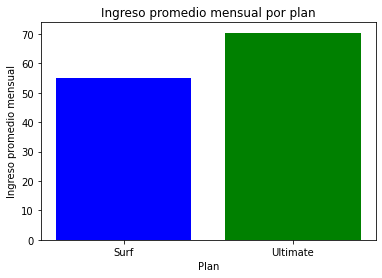

In [65]:

# Calcular el ingreso promedio mensual para cada plan
surf_mean_income = surf_users['monthly_income'].mean()
ultimate_mean_income = ultimate_users['monthly_income'].mean()

# Crear una lista con los ingresos promedio para cada plan
mean_incomes = [surf_mean_income, ultimate_mean_income]
plan_labels = ['Surf', 'Ultimate']
plt.bar(plan_labels, mean_incomes, color=['blue', 'green'])
plt.title('Ingreso promedio mensual por plan')
plt.xlabel('Plan')
plt.ylabel('Ingreso promedio mensual')
plt.show()


In [66]:
print('Varianza mensual Surf:', np.var(surf_users['monthly_income']))
print('Varianza mensual Ultimate:', np.var(ultimate_users['monthly_income']))

Varianza mensual Surf: 1745.0731632860968
Varianza mensual Ultimate: 7.7580161795425


Ingreso Promedio Mensual por Plan:
Esto sugiere que, en promedio, los usuarios del plan "Ultimate" generan un ingreso mensual más alto en comparación con los usuarios del plan "Surf".

Varianza Mensual por Plan:

La varianza mide la dispersión de los datos alrededor del valor medio. Una varianza menor indica que los valores tienden a estar más cerca del valor medio, mientras que una varianza mayor indica una dispersión más amplia.
La varianza mensual para el plan "Surf" es considerablemente mayor que la del plan "Ultimate". Esto sugiere que los ingresos mensuales de los usuarios del plan "Surf" tienden a ser más variables que los ingresos mensuales de los usuarios del plan "Ultimate".En resumen, aunque el plan "Ultimate" tiene un ingreso promedio mensual más alto, también parece tener una varianza mensual mucho menor en comparación con el plan "Surf". Esto podría indicar una mayor estabilidad en los ingresos mensuales para el plan "Ultimate".


## Prueba las hipótesis estadísticas

In [67]:
# Prueba las hipótesis
sample_1 = surf_users['monthly_income']
sample_2 = ultimate_users['monthly_income']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('pvalue:', results.pvalue)
alpha = 0.05

if results.pvalue < alpha:
    print("Con un valor p de {:.4f}, rechazamos la hipótesis nula.".format(results.pvalue))
else:
    print("Con un valor p de {:.4f}, no podemos rechazar la hipótesis nula.".format(results.pvalue))
   

pvalue: 3.566128278537705e-32
Con un valor p de 0.0000, rechazamos la hipótesis nula.


In [68]:
user_monthly_data['region'] = user_monthly_data['city'].apply(lambda city: 'ny-nj' if 'NY-NJ' in city or 'NY' in city or 'NJ' in city else 'other')


In [69]:
user_monthly_data['region'].value_counts(dropna=False)

other    1814
ny-nj     489
Name: region, dtype: int64

In [70]:
ny_nj = user_monthly_data[user_monthly_data['region'] == 'ny-nj']
other = user_monthly_data[user_monthly_data['region'] == 'other']


In [71]:
print('Ingreso promedio mensual región NY-NJ:', ny_nj['monthly_income'].mean())
print('Ingreso promedio mensual otras regiones:', other['monthly_income'].mean())
print()
print('Varianza ingreso mensual región NY-NJ:', np.var(ny_nj['monthly_income']))
print('Varianza ingreso mensual otras regiones:', np.var(other['monthly_income']))

Ingreso promedio mensual región NY-NJ: 61.37701431492843
Ingreso promedio mensual otras regiones: 65.01864388092609

Varianza ingreso mensual región NY-NJ: 2101.7204041736195
Varianza ingreso mensual otras regiones: 2183.903236749693


In [72]:
# Prueba las hipótesis
sample_1 = ny_nj['monthly_income']
sample_2 = other['monthly_income']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('pvalue:', results.pvalue)
alpha = 0.05  

if results.pvalue < alpha:
    print("Con un valor p de {:.4f}, rechazamos la hipótesis nula.".format(results.pvalue))
else:
    print("Con un valor p de {:.4f}, no rechazamos la hipótesis nula.".format(results.pvalue))

pvalue: 0.12126002617160894
Con un valor p de 0.1213, no rechazamos la hipótesis nula.


Los usuarios del Plan Ultimate generan más ingresos promedio mensuales para Megaline que los del Plan Surf, confirmado por pruebas de hipótesis.
No se encontraron diferencias significativas en el ingreso promedio mensual entre clientes de la región NY-NJ y otras regiones.
El plan Surf muestra una varianza de ingresos mensuales más alta, sugiriendo que más clientes superan los límites de la tarifa establecida en comparación con el plan Ultimate.
Se recomienda a Megaline enfocar su publicidad en el plan Ultimate o considerar migrar clientes del plan Surf a este plan, ya que algunos clientes del plan Surf superan los límites mensuales, lo que podría ser más beneficioso tanto para los clientes como para la empresa.

## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

Conclusiones del Procesamiento de Datos:

Se corrigieron errores en el formato de fechas y se trataron valores faltantes en varios conjuntos de datos.
Se redondearon valores de llamadas y se convirtieron unidades de datos para ajustarse a las prácticas de Megaline.
Los límites de consumo de datos en el conjunto de datos de planes fueron convertidos de MB a GB.

Conclusiones sobre el Enriquecimiento de Datos:

Se agregó información detallada de consumo para cada usuario mediante agrupaciones de datos y uniones de datos.
Se calcularon los ingresos mensuales de los usuarios considerando su consumo y plan.

Análisis Estadístico y Pruebas de Hipótesis:

Los usuarios del Plan Ultimate generan ingresos mensuales más altos que los del Plan Surf.
No se encontraron diferencias significativas en los ingresos entre los residentes de NY-NJ y otras regiones.
La varianza en los ingresos mensuales para el plan Surf fue alta, sugiriendo que más usuarios exceden los límites de consumo en comparación con el plan Ultimate.
Basado en estos hallazgos, se recomienda a Megaline dirigir su presupuesto publicitario hacia el plan Ultimate o explorar la migración de usuarios de Surf a Ultimate debido a su mayor potencial de ingresos.